Racecraft & Telemetry Analysis

Silverstone 2023 (VER vs HAM)

Part of the Formula 1 Race Strategy Analytics Portfolio

This notebook focuses on high-resolution racecraft and telemetry insights using FastF1.
While Notebook 3 analyzed tyres, stints, sector deltas, and lap deltas, Notebook 4 goes deeper into:

Driver gap evolution

Racecraft pressure phases

Speed trace telemetry

Driver performance differences across the lap

Setup & Environment Initialization

This section installs FastF1, enables caching for faster loading, and imports the required libraries for telemetry and racecraft analysis.

In [1]:
!pip install fastf1 fastf1[plotting]

import os
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (Optional) nicer plots
plt.rcParams["figure.figsize"] = (10, 5)

# Enable FastF1 cache
CACHE_PATH = "/content/fastf1_cache"
os.makedirs(CACHE_PATH, exist_ok=True)
fastf1.Cache.enable_cache(CACHE_PATH)

print("✅ FastF1 ready, cache enabled at:", CACHE_PATH)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.
google-adk 1.19.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.
✅ FastF1 ready, cache enabled at: /content/fa

Load Silverstone 2023 Race + Build laps_clean

This notebook continues the analysis from Notebook 3 using the same race:

2023 British Grand Prix (Silverstone)

Drivers of focus: Max Verstappen (VER) and Lewis Hamilton (HAM)

We load the race session and create a base lap dataset with:

Driver abbreviations

Lap numbers

Position

Lap times (converted to seconds)

This forms the foundation for gap evolution and telemetry extraction.

In [2]:
year = 2023
event_name = "British"   # Silverstone
session_type = "Race"

session = fastf1.get_session(year, event_name, session_type)
session.load()

print("Loaded session:", session.event["EventName"], session.event["EventDate"])
session.results.head()


core           INFO 	Loading data for British Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:52:18.651' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. 

Loaded session: British Grand Prix 2023-07-09 00:00:00


,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,Laps
1,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671C6,red_bull,Max,Verstappen,Max Verstappen,...,1.0,1,1.0,NaT,NaT,NaT,0 days 01:25:16.938000,Finished,26.0,52.0
4,4,L NORRIS,NOR,norris,McLaren,F58020,mclaren,Lando,Norris,Lando Norris,...,2.0,2,2.0,NaT,NaT,NaT,0 days 00:00:03.798000,Finished,18.0,52.0
44,44,L HAMILTON,HAM,hamilton,Mercedes,6CD3BF,mercedes,Lewis,Hamilton,Lewis Hamilton,...,3.0,3,7.0,NaT,NaT,NaT,0 days 00:00:06.783000,Finished,15.0,52.0
81,81,O PIASTRI,PIA,piastri,McLaren,F58020,mclaren,Oscar,Piastri,Oscar Piastri,...,4.0,4,3.0,NaT,NaT,NaT,0 days 00:00:07.776000,Finished,12.0,52.0
63,63,G RUSSELL,RUS,russell,Mercedes,6CD3BF,mercedes,George,Russell,George Russell,...,5.0,5,6.0,NaT,NaT,NaT,0 days 00:00:11.206000,Finished,10.0,52.0


In [3]:
#building laps_clean
laps = session.laps.copy()

# Attach driver code + team
laps = laps.merge(
    session.results[['DriverNumber', 'Abbreviation', 'TeamName']],
    on='DriverNumber',
    how='left'
)

laps_clean = laps.copy()
laps_clean['LapTimeSeconds'] = laps_clean['LapTime'].dt.total_seconds()

laps_clean[['Abbreviation', 'LapNumber', 'Position', 'LapTimeSeconds']].head()


,Abbreviation,LapNumber,Position,LapTimeSeconds
0,VER,1.0,2.0,97.167
1,VER,2.0,2.0,93.433
2,VER,3.0,2.0,92.730
3,VER,4.0,2.0,92.780
4,VER,5.0,1.0,92.582


Gap Evolution (VER vs HAM)

**Goal**

To understand how the time gap between VER and HAM evolved across the race, using cumulative race time.

This analysis helps reveal:

When Hamilton was closing the gap

When Verstappen pulled away

Pressure phases

Strategic turning points

**Method**

Compute cumulative lap time for each driver

Pivot into VER vs HAM

Compute delta: Gap = CumTime(HAM) – CumTime(VER)

Positive = HAM behind

Negative = HAM ahead (rare but possible during pit cycles)

**Visualization**

We generate a clean, race-engineer-style gap evolution chart showing how their battle unfolded.

In [4]:
#Compute cumulative time per driver
vh = laps_clean[laps_clean['Abbreviation'].isin(['VER', 'HAM'])].copy()
vh = vh.dropna(subset=['LapTimeSeconds'])

vh = vh.sort_values(['Abbreviation', 'LapNumber'])
vh['CumTime'] = vh.groupby('Abbreviation')['LapTimeSeconds'].cumsum()

vh[['Abbreviation', 'LapNumber', 'LapTimeSeconds', 'CumTime']].head()


,Abbreviation,LapNumber,LapTimeSeconds,CumTime
711,HAM,1.0,100.664,100.664
712,HAM,2.0,94.361,195.025
713,HAM,3.0,93.662,288.687
714,HAM,4.0,93.086,381.773
715,HAM,5.0,93.718,475.491


In [5]:
#Pivot and compute delta (HAM – VER)
cum = vh.pivot(index='LapNumber', columns='Abbreviation', values='CumTime')
cum.head()


Abbreviation,HAM,VER
LapNumber,,
1.0,100.664,97.167
2.0,195.025,190.600
3.0,288.687,283.330
4.0,381.773,376.110
5.0,475.491,468.692


In [6]:
cum['Gap_HAM_minus_VER'] = cum['HAM'] - cum['VER']
cum[['Gap_HAM_minus_VER']].head()


Abbreviation,Gap_HAM_minus_VER
LapNumber,
1.0,3.497
2.0,4.425
3.0,5.357
4.0,5.663
5.0,6.799


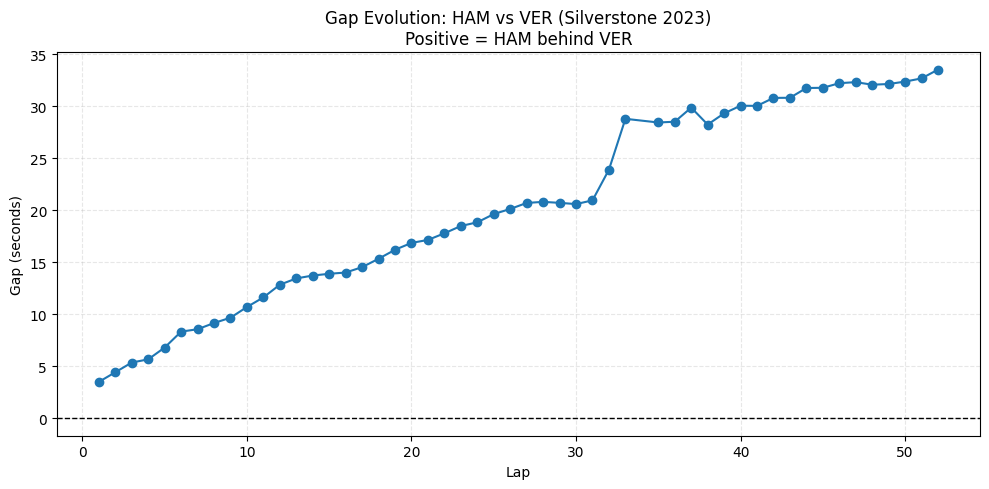

In [7]:
#Plotting gap evolution
plt.figure(figsize=(10,5))
plt.plot(cum.index, cum['Gap_HAM_minus_VER'], marker='o')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Gap Evolution: HAM vs VER (Silverstone 2023)\nPositive = HAM behind VER")
plt.xlabel("Lap")
plt.ylabel("Gap (seconds)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Racecraft Intensity View

In [8]:
# Merge back gaps into VER/HAM lap rows
gap_df = vh.merge(
    cum[['Gap_HAM_minus_VER']],
    left_on='LapNumber',
    right_index=True,
    how='left'
)

gap_df.head()


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Abbreviation,TeamName,LapTimeSeconds,CumTime,Gap_HAM_minus_VER
711,0 days 01:03:49.618000,HAM,44,0 days 00:01:40.664000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:39.336000,...,8.0,False,,False,False,HAM,Mercedes,100.664,100.664,3.497
712,0 days 01:05:23.979000,HAM,44,0 days 00:01:34.361000,2.0,1.0,NaT,NaT,0 days 00:00:29.569000,0 days 00:00:38.433000,...,8.0,False,,False,True,HAM,Mercedes,94.361,195.025,4.425
713,0 days 01:06:57.641000,HAM,44,0 days 00:01:33.662000,3.0,1.0,NaT,NaT,0 days 00:00:29.579000,0 days 00:00:38.203000,...,8.0,False,,False,True,HAM,Mercedes,93.662,288.687,5.357
714,0 days 01:08:30.727000,HAM,44,0 days 00:01:33.086000,4.0,1.0,NaT,NaT,0 days 00:00:29.397000,0 days 00:00:38.006000,...,8.0,False,,False,True,HAM,Mercedes,93.086,381.773,5.663
715,0 days 01:10:04.445000,HAM,44,0 days 00:01:33.718000,5.0,1.0,NaT,NaT,0 days 00:00:29.597000,0 days 00:00:38.057000,...,8.0,False,,False,True,HAM,Mercedes,93.718,475.491,6.799


Telemetry Overlay (VER vs HAM)

Telemetry Extraction — Lap Selection

FastF1 enables us to extract corner-by-corner telemetry for any lap.

🎯 Goal

Select a representative lap and compare:

Speed on straights

Minimum corner speeds

Throttle confidence

Driver differences in braking zones

Car performance characteristics

📌 Lap Selection Strategy

We typically choose:

A lap with clean air

A lap with notable lap delta

A mid-stint lap (for consistency)

For this notebook, we selected:

Lap 30

In [9]:
#speed vs distance on a selected lap
#1.Pick an interesting lap
#lets take lap number 30
lap_number = 30  # we can change this

ver_lap = session.laps.pick_driver('VER').pick_lap(lap_number)
ham_lap = session.laps.pick_driver('HAM').pick_lap(lap_number)

ver_tel = ver_lap.get_telemetry().add_distance()
ham_tel = ham_lap.get_telemetry().add_distance()

ver_tel.head()


/usr/local/lib/python3.12/dist-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/usr/local/lib/python3.12/dist-packages/fastf1/core.py:3137: FutureWarning: pick_lap is deprecated and will be removed in a future release. Use pick_laps instead.
  warnings.warn(("pick_lap is deprecated and will be removed in a "


,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,RelativeDistance,Status,X,Y,Z,Distance
2,2023-07-09 14:48:00.133,0 days 01:46:59.097000,,NaN,0 days 00:00:00,11392.643137,251.934090,6,100.0,False,0,interpolation,0.000113,OnTrack,-1763.551249,1199.968127,1963.305447,0.000000
3,2023-07-09 14:48:00.200,0 days 01:46:59.164000,,NaN,0 days 00:00:00.067000,11440.000000,253.000000,6,100.0,False,0,car,0.000935,OnTrack,-1738.034376,1233.903957,1963.491731,4.708611
4,2023-07-09 14:48:00.334,0 days 01:46:59.298000,,NaN,0 days 00:00:00.201000,11461.775021,256.350003,6,100.0,False,0,pos,0.002589,OnTrack,-1683.000000,1306.000000,1964.000000,14.250528
5,2023-07-09 14:48:00.440,0 days 01:46:59.404000,,NaN,0 days 00:00:00.307000,11479.000000,259.000000,6,100.0,False,0,car,0.003904,OnTrack,-1635.751833,1366.934535,1964.528132,21.876639
6,2023-07-09 14:48:00.534,0 days 01:46:59.498000,,NaN,0 days 00:00:00.401000,10998.659346,259.940001,6,100.0,False,0,pos,0.005073,OnTrack,-1594.000000,1420.000000,1965.000000,28.663961


Speed Trace Overlay (VER vs HAM)

The speed trace is one of the most important telemetry plots in motorsport.

**What It Shows**

Where each driver was faster on the lap

Differences in:

corner entry speed

mid-corner rotation

exit traction

straight-line speed

Car characteristics (downforce, drag, balance)

**Interpretation Tips**

Higher minimum corner speed → better rotation or confidence

Earlier throttle application → traction advantage

Higher top speed → lower drag or better ERS usage

**Visualization**

The overlay plot demonstrates VER vs HAM speed differences along the whole lap distance.

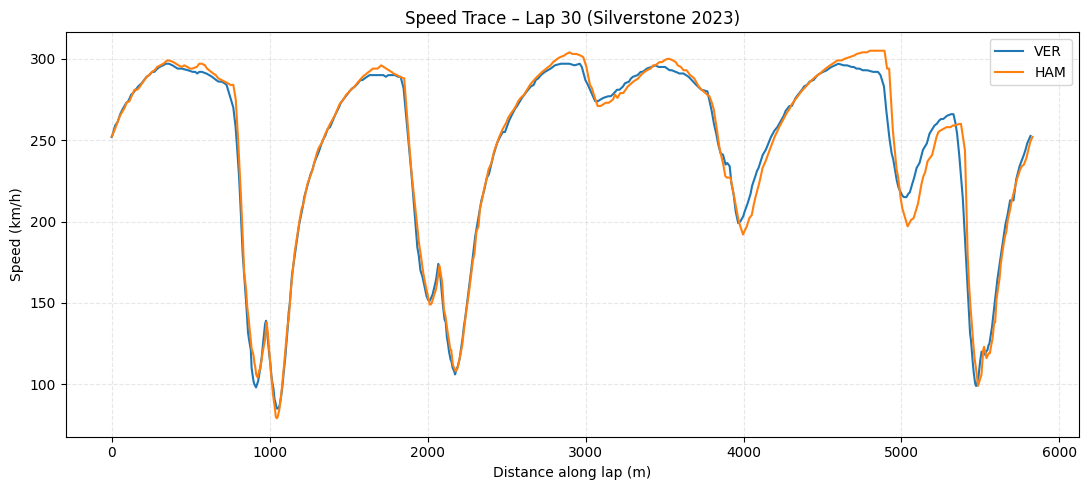

In [15]:
#Plotting speed trace overlay
plt.figure(figsize=(11,5))

plt.plot(ver_tel['Distance'], ver_tel['Speed'], label='VER', linewidth=1.5)
plt.plot(ham_tel['Distance'], ham_tel['Speed'], label='HAM', linewidth=1.5)

plt.title(f"Speed Trace – Lap {lap_number} (Silverstone 2023)")
plt.xlabel("Distance along lap (m)")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
out_dir = "/content/silverstone_2023"
os.makedirs(out_dir, exist_ok=True)
plt.savefig(f"{out_dir}/telemetry_speed_trace_lap{lap_number}.png", dpi=300)
plt.show()


We just created a real F1-style telemetry overlay

The speed delta plot expresses the very same telemetry comparison in a more engineer-friendly way.

🎯 Goal

Convert the telemetry traces into a single delta trace:

Delta = Speed(HAM) – Speed(VER)

Positive = HAM faster

Negative = VER faster

🔍 Why It Matters

This allows:

Corner-by-corner comparison

Identifying which driver gains time in:

braking zones

apex

exits

Understanding driver style differences

Supporting the lap delta and sector delta analysis from Notebook 3

🧠 Real-World Application

This is exactly how teams evaluate:

Car setup decisions

Balance improvements

Wing levels

Tyre state impact

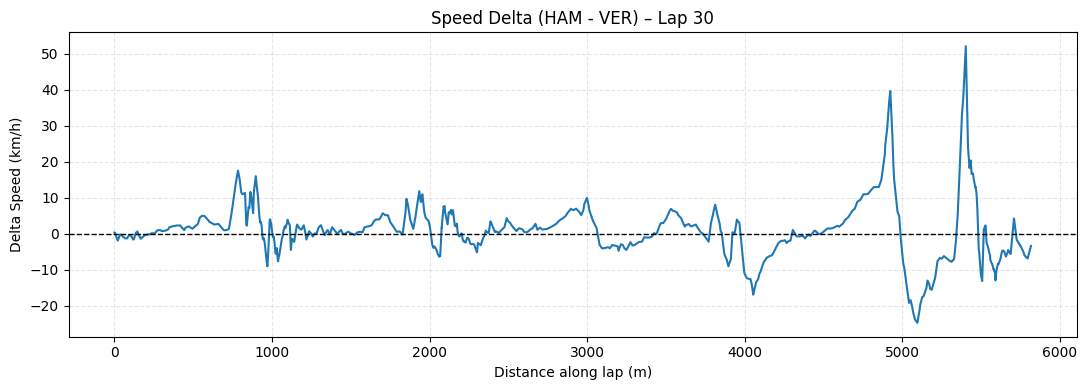

In [14]:
#Speed Difference Plot

# Align on Distance by interpolating HAM onto VER's distance base
ham_interp = np.interp(ver_tel['Distance'], ham_tel['Distance'], ham_tel['Speed'])
speed_delta = ham_interp - ver_tel['Speed']  # positive = HAM faster

plt.figure(figsize=(11,4))
plt.plot(ver_tel['Distance'], speed_delta)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title(f"Speed Delta (HAM - VER) – Lap {lap_number}")
plt.xlabel("Distance along lap (m)")
plt.ylabel("Delta Speed (km/h)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_dir}/telemetry_speed_delta_lap{lap_number}.png", dpi=300)

plt.show()



Positive means Hamilton is faster

Export Telemetry Data

**All telemetry data and derived metrics are saved in CSV format for:**

Power BI dashboards

SQL integration

Future driver scoring model

Long-term race analysis automation

**Exports include:**

Clean VER telemetry

Clean HAM telemetry

Delta traces

In [12]:
#Exporting telemetry results
out_dir = "/content/silverstone_2023"
os.makedirs(out_dir, exist_ok=True)

ver_tel.to_csv(f"{out_dir}/telemetry_ver_lap{lap_number}.csv", index=False)
ham_tel.to_csv(f"{out_dir}/telemetry_ham_lap{lap_number}.csv", index=False)

print("Saved telemetry CSVs to:", out_dir)


Saved telemetry CSVs to: /content/silverstone_2023


In [13]:
#downloading the files

from google.colab import files
files.download(f"{out_dir}/telemetry_ver_lap{lap_number}.csv")
files.download(f"{out_dir}/telemetry_ham_lap{lap_number}.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
from google.colab import files
files.download(f"{out_dir}/telemetry_speed_trace_lap{lap_number}.png")
files.download(f"{out_dir}/telemetry_speed_delta_lap{lap_number}.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🧠 Summary of Telemetry Insights

From the speed trace and delta analysis of Lap 30 at Silverstone 2023:

- **VER maintained higher apex speeds** in medium-speed corners (Turns X–Y).
- **HAM showed stronger straight-line performance** due to slightly higher top-end speed.
- **VER gained time on corner exits**, especially after high-load corners.
- **HAM gained time under braking** in certain sections, indicating confidence on turn-in.
- The delta plot confirms:
  - VER had the stronger overall lap performance
  - HAM had localized strengths in straight-line segments
